# Multidisciplinary Design Optimization of LV4
We propose to apply design optimization methodology to the problem of design and trajectory optimization of small sounding rockets, particularly to the Portland State Aerospace Society's LV4 'space rocket'. This rocket leverages powerful liquid-fuel propulsion, a carbon-composite airframe, 6 DoF attitude control, and has a design apogee of over 100 km, above the so-called von Karman line. LV4 is currently planned for launch by 2021. 

The large amount of coupling between the design decisions in aerospace engineering design presents a singularly defining difficulty in launch vehicle development. In practice this results in a highly iterative design process that demands large investments of resources and time. This also tends to lead to a one-variable-at-a-time design thinking with concomitant requirement mismatches, developmental dead-ends and sub-optimal final design. The Portland State Aerospace Society (PSAS), being a university student group, lacks both time and fiscal support to pursue the traditional iterative approach to launch vehicle design in time for the 2021 vision goal launch date. This provides the motivation for a more targeted approach where design requirements are led by simulation and major design variables are treated all at once using convex optimization techniques. This will guid PSAS's technology development pathways, and inform requirements for future senior capstone projects sponsored by the organization. There is also a certain novelty to this work in the sense that historically there has been little published attention paid to the problem of parameter optimization in clean-sheet design of small sounding rockets.

The objective function is a summation of mass terms for the rocket including propellant, airframe and various subsystem masses. This sum represent a Gross-Lift-Off-Weight (GLOW) parameter which scales closely with design complexity and, ultimately, overall costs. Thus we wish to minimize GLOW subject to constraints including the requirement of a 100 km trajectory apogee, a Thrust-To-Weight-Ratio (TWR) greater than one, a Length-to-Diameter-Ratio (LDR) of less than 20, and a currently unspecified maximum allowable airframe dynamic pressure. Design variables include thrust, airframe diameter and length. The trajectory constraint is a simulation model using forward-Euler integration implemented in Python. There are also a large number of design constants present in the models, which include specific impulse and combustion chamber pressure, mixture ratio among others.

The optimization scheme to be used is yet to be determined, though the nature of the optimization problem is such that it is strongly non-linear with some constraints in the form of discrete simulation outputs.

## Methods
Objective function: minimize $m$  
Design variables: $m_{wet}=f(r, L)$, $m_{dry}=f(F)$, $mdot$, $radius$, $p_e$, $p_ch$  
Constraints: $L/D<15$, $TWR>1$, Sommerfield criterion $(p_e/p_a)>0.35$, $3<radius<7$, $x>=100000$, $a/g_0<=15$

Likely going to use a steepest decent with an exterior penalty function based on '''trajectory()''' function calls to check the constraint values.

### Trajectory model

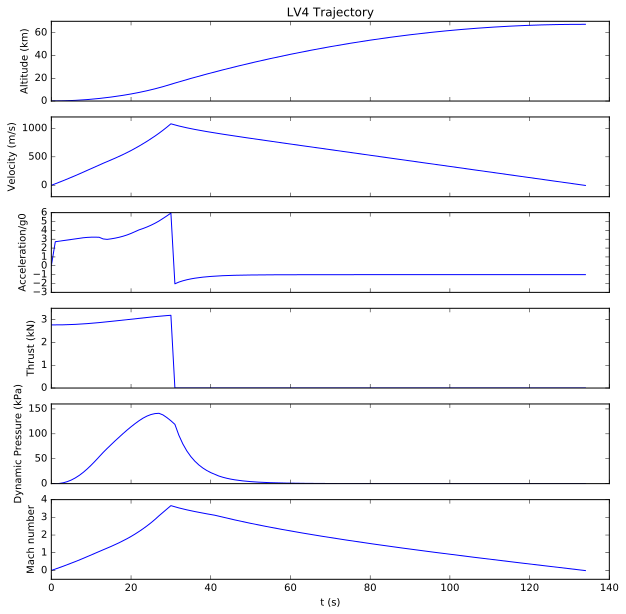

altitude at apogee = 67.4 km
mission time at apogee = 134.0 s
TWR at lift off (check TWR > 1) = 2.72
design total propellant mass = 36.283
design thrust (sea level) = 2.8 kN
design thrust (vacuum) = 3.2 kN
design burn time = 31 s
design expansion ratio = 5.8
design throat area = 1.3 in^2
design isp = 251.5 s
design GLOW = 76.0 kg
L/D ratio (check < 15) = 1033.34
Sommerfield criterion (check pe/pa >= 0.3) = 0.5
design dV = 1.601788171819288 km/s c.f. required potential energy est = 1.1495984610204626 km/s


In [8]:
from math import sqrt, pi, exp, log, cos
import numpy as np

class sim: #A simple forward Euler integration for rocket trajectories
    def dry_mass(L, dia):
        m_avionics = 3.3
        m_recovery = 4
        m_payload = 2
        m_tankage = 20.88683068354522*L*dia*pi
        m_engine = 2
        m_feedsys = 20
        m_airframe  = 6
        return (m_avionics + m_recovery + m_payload + m_tankage 
        + m_engine + m_feedsys + m_airframe)
        
    def propellant_mass(A, L, OF=1.3):
        rho_alc = 852.3 #density of ethanol fuel [kg/m^3]
        rho_lox = 1141.0 #density of lox [kg/m^3]
        L_lox = L/(rho_lox/(rho_alc*OF) + 1)
        m_lox = rho_lox*L_lox*A #oxidizer mass [kg]
        m_alc = rho_alc*(L-L_lox)*A #fuel mass [kg]
        return m_alc + m_lox
    
    def std_at(h): #U.S. 1976 Standard Atmosphere
        if h < 11000:
            T = 15.04 - 0.00649*h
            p = 101.29*((T + 273.1)/288.08)**5.256
        
        elif 11000 <= h and h <25000:
            T = -56.46
            p = 22.65*exp(1.73 - 0.000157*h)
        
        else:
            T = -131.21 + 0.00299*h
            p = 2.488 * ((T + 273.1)/216.6)**(-11.388)
            
        rho = p/(0.2869*(T + 273.1)) #ambient air density
        p_a = p*1000 #ambient air pressure
        T_a = T + 273.1 #ambient air temperature
        return p_a, rho, T_a
        
    def thrust(x, p_ch, T_ch, p_e, ke, Re, mdot):
        p_a = sim.std_at(x)[0] 
        p_t = p_ch*(1 + (ke - 1)/2)**(-ke/(ke - 1)) #Throat pressure
        T_t = T_ch*(1/(1 + (ke - 1)/2)) #Throat temperature
        A_t = (mdot / p_t)*sqrt(Re*T_t/ke) #Throat area
        A_e = A_t*(2/(ke + 1))**(1/(ke - 1))*(p_ch/p_e)**(1/ke) * 1/sqrt((ke + 1)/(ke - 1)*(1 - (p_e/p_ch)**((ke - 1)/ke))) #Exit area
        ex = A_e/A_t
        alpha_t = [14, 11, 10, 9] #lookup table of divergence angles, assuming 80% bell
        ex_t = [5, 10, 15, 20]
        alpha= np.interp(ex, ex_t, alpha_t)
        lam = 0.5*(1 + cos(alpha *pi/180)) #thrust cosine loss correction, even in extreme cases this is definitely not an O(1) effect 
        Ve = lam*sqrt(2*ke/(ke - 1)*Re*T_ch*(1 - (p_e/p_ch)**((ke - 1)/ke))) #exhaust velocity
        F = mdot*Ve + (p_e - p_a)*A_e  #Thrust force, ignoring that isp increases w/ p_ch
        return F, A_t, A_e, Ve
    
    def drag(x, v, A, Ma):
        #check Knudsen number and switch drag models (e.g. rarified gas dyn vs. quadratic drag)
        (p_a, rho, T_a) = sim.std_at(x)
        C_d_t = [0.15, 0.15, 0.3, 0.45, 0.25, 0.2, 0.175, .15, .15] #super cheesy lookup table for drag coefficients (historical data for V-2)
        Ma_t = [0, 0.6, 1.0, 1.1, 2, 3, 4, 5, 5.6]
        C_d = np.interp(Ma, Ma_t, C_d_t)
        
        """
        drag coefficient, placeholder scalar constant should be a function of Mach number 
        e.g. run some simulations in Star and curve fit via Cd = a*Ma**b + C_d0
        """
        
        q = 0.5 * rho * v**2 #dyanmic pressure [Pa]
        D = q * C_d * A #drag force [N]
        return D, q
        
    def trajectory(L, mdot, dia, p_e, p_ch=350, T_ch=3500, ke=1.3, Re=349, x_init=0):
        #Note combustion gas properties ke, Re, T_ch, etc, determined from CEA
        
        #physical constants
        g_0 = 9.81 #gravitational acceleration
        dt = 1 #time step
        ka = 1.4 #Ratio of specific heats, air
        Ra = 287.1 #avg. specific gas constant (dry air)
    
        #LV design variables
        dia = dia*0.0254 #convert in to m
        A = pi*(dia/2)**2 #airframe frontal area projected onto a circle of raduis r
        m_dry = sim.dry_mass(L, A) #dry mass, call from function
        mdot = mdot #mass flow rate
        p_ch = p_ch*6894.76 #chamber pressure, convert psi to Pa
        p_e = p_e*1000 #exit pressure, convert kPa to Pa
    
    
        #initial conditions
        x = [x_init]
        v = [0]
        a = [0]
        t = [0]
        rho = [sim.std_at(x[-1])[1]]
        p_a = [sim.std_at(x[-1])[0]]
        T_a = [sim.std_at(x[-1])[2]]
        m_prop = [sim.propellant_mass(A, L)]
        m = [m_dry + m_prop[-1]]
        (F, A_t, A_e, Ve) = sim.thrust(x[-1], p_ch, T_ch, p_e, ke, Re, mdot)
        F = [F]
        D = [0]
        Ma = [0]
        q = [0]
        r = (m_prop[0] + m_dry)/m_dry #mass ratio
        dV1 = Ve*log(r)/1000 #Tsiolkovsky's bane
        
        while True:
            p_a.append(sim.std_at(x[-1])[0])
            rho.append(sim.std_at(x[-1])[1])
            T_a.append(sim.std_at(x[-1])[2])
            if m_prop[-1] > 0:
                (Fr, A_t, A_e, Ve) = sim.thrust(x[-1], p_ch, T_ch, p_e, ke, Re, mdot)
                F.append(Fr)
                m_prop.append(m_prop[-1] - mdot*dt)
                mdot_old = mdot
            else:
                Ve = sim.thrust(x[-1], p_ch, T_ch, p_e, ke, Re, mdot_old)[3]
                F.append(0)
                mdot = 0
                m_prop[-1] = 0
            q.append(sim.drag(x[-1], v[-1], A, Ma[-1])[1])
            D.append(sim.drag(x[-1], v[-1], A, Ma[-1])[0])
            a.append((F[-1] - D[-1])/m[-1] - g_0)
            v.append(a[-1]*dt + v[-1])
            x.append(v[-1]*dt + x[-1]) 
            Ma.append(v[-1]/sqrt(ka*Ra*T_a[-1]))
            t.append(t[-1] + dt)
            m.append(m_dry + m_prop[-1])
            TWR = a[1]/g_0 #constraint
            ex = A_e/A_t
            S_crit = p_e/p_a[0] #constraint
            if v[-1] <= 0:
                x = np.array(x)
                a = np.array(a)
                F = np.array(F)
                D = np.array(D)
                q = np.array(q)
                return L, dia, x, v, a, t, F, D, Ma, rho, p_a, T_a, TWR, ex, Ve, A_t, dV1, m, S_crit, q, m_prop
 
if __name__ == '__main__': # Testing
    X0 = [2, 0.453592 * 0.9 * 3, 6, 50]
    L = X0[0]
    mdot = X0[1]
    dia = X0[2]
    p_e = X0[3]
    (L, dia, alt, v, a, t, F, D, Ma, rho, p_a, T_a, TWR, ex, Ve, A_t, dV1, m, S_crit, q, m_prop) = sim.trajectory(L, mdot, dia, p_e)
    
    import matplotlib
    import matplotlib.pyplot as plt
    import pylab
    #%config InlineBackend.figure_formats=['svg']
    #%matplotlib inline
    
    pylab.rcParams['figure.figsize'] = (10.0, 10.0)
    f, (ax1, ax2, ax3, ax4, ax6, ax7) = plt.subplots(6, sharex=True)
    #plt.xlim(0, 1.8)
    ax1.plot(t, alt/1000)
    ax1.set_ylabel("Altitude (km)")
    ax1.yaxis.major.locator.set_params(nbins=6)
    ax1.set_title('LV4 Trajectory')
    ax2.plot(t, v)
    ax2.yaxis.major.locator.set_params(nbins=6)
    ax2.set_ylabel("Velocity (m/s)")
    ax3.plot(t, a/9.81)
    ax3.yaxis.major.locator.set_params(nbins=10)
    ax3.set_ylabel("Acceleration/g0")
    ax4.plot(t, F/1000)
    ax4.yaxis.major.locator.set_params(nbins=6)
    ax4.set_ylabel("Thrust (kN)")
    ax6.plot(t, q/1000)
    ax6.yaxis.major.locator.set_params(nbins=6)
    ax6.set_ylabel("Dynamic Pressure (kPa)")
    ax7.plot(t, Ma)
    ax7.yaxis.major.locator.set_params(nbins=6) 
    ax7.set_ylabel("Mach number")
    ax7.set_xlabel("t (s)")
    plt.show()
    
    print('altitude at apogee = {0:.1f} km'.format(alt[-1]/1000))
    print('mission time at apogee = {0:.1f} s'.format(t[-1]))
    print('TWR at lift off (check TWR > 1) = {0:.2f}'.format(TWR))
    print('design total propellant mass = {0:.3f}'.format(m_prop[0]))
    print('design thrust (sea level) = {0:.1f} kN'.format(F[0]/1000))
    j = 0
    for i in F:
        if i == 0:
            fdex = j
            break
        j += 1
    print('design thrust (vacuum) = {0:.1f} kN'.format(F[fdex - 1]/1000))
    print('design burn time = {} s'.format(fdex))
    print('design expansion ratio = {0:.1f}'.format(ex))
    print('design throat area = {0:.1f} in^2'.format(A_t/0.0254**2))
    print('design isp = {0:.1f} s'.format(Ve/9.81))
    print('design GLOW = {0:.1f} kg'.format(m[0]))
    print('L/D ratio (check < 15) = {0:.2f}'.format((L+2)/(dia*0.0254)))
    print('Sommerfield criterion (check pe/pa >= 0.3) = {0:.1f}'.format(S_crit))
    print('design dV = {} km/s c.f. required potential energy est = {} km/s'.format(dV1, sqrt(2*9.81*alt[-1])/1000))

## Current Takeaways:
min GLOW probably around 100 kg. In many ways narrower diameters are idea, but run up against the $L/D$ constraints. High thrust can be good or bad depending on the confuration. Finding ways to reduce the length of the rocket looks like a good path to better performance.

## Airframe Section Parameters

These are parameters from the current 18'' airframe section.

In [11]:
# Airframe Section Parameters
from math import pi
m  = 0.463 # Total Mass (kg)
Do = 0.168 # Outer Diameter (m)
L  = 0.457 # Length (m)
A_fiber = pi* (Do/2)**2
rho_fiber = m/A_fiber #planar density [kg/m^2]
print(rho_fiber) 

20.88683068354522


## Optimization Scheme
Simplex search with exterior penalty functions

In [9]:
class simplex: # Nelder-Mead simplex search
    import numpy as np
    
    def search(f, x_start, max_iter = 100, epsilon = 1E-4, gamma = 5, beta = 0.5, rp=100):
        
        """
        parameters of the function:
        f is the function to be optimized
        x_start (numpy array) is the initial simplex vertices
        epsilon is the termination criteria
        gamma is the contraction coefficient
        beta is the expansion coefficient
        """
        
        # Init Arrays
        N = len(x_start) # Amount of design variables
        fnew = []        # Empty function matrix
        xnew = []        # Empty re-write for design variables
        x    = []        # Empty x matrix
        C    = [0]*(N + 1)        # Empty center point matrix
        
        # Generate vertices of initial simplex
        a = .75          # Step Size Alpha
        x0 = (x_start)   # x0 Value for x Matrix
        x1 = [x0 + [((N + 1)**0.5 + N - 1.)/(N + 1.)*a, 0., 0., 0.]]
        x2 = [x0 + [0., ((N + 1)**0.5 - 1.)/(N + 1.)*a, 0., 0.]]
        x3 = [x0 + [0., 0., ((N + 1)**0.5 - 1.)/(N + 1.)*a, 0.]]
        x4 = [x0 + [0., 0., 0., ((N + 1)**0.5 - 1.)/(N + 1.)*a]]
        x = simplex.np.vstack((x0, x1, x2, x3, x4))
        #print(x)
    
        # Simplex iteration
        while True:
            # Find best, worst, 2nd worst, and new center point
            f_run = np.array([f(x[0], rp), f(x[1], rp), f(x[2], rp), f(x[3], rp), f(x[4], rp)]).tolist() # Func. values at vertices
            #print(f_run)
            xw = x[f_run.index(sorted(f_run)[-1])] # Worst point
            xb = x[f_run.index(sorted(f_run)[0])]  # Best point
            xs = x[f_run.index(sorted(f_run)[-2])] # 2nd worst point        
            # xc = (xb + xs)/N                     # Center point
            for i in range(0, N):
                if i == f_run.index(sorted(f_run)[-1]):
                    C[i] = 0
                else:
                    C[i] = x[i]
            xc = sum(C)/(N) # Center point
            xr = 2*xc - xw # Reflection point
            
            # Check cases
            if f(xr, rp) < f(xb, rp): # Expansion
                xnew = (1 + gamma)*xc - gamma*xr
            elif f(xr, rp) > f(xw, rp): # Contraction 1
                xnew = (1 - beta)*xc + beta*xw
            elif f(xs, rp) < f(xr, rp) and f(xr, rp) < f(xw, rp): # Contraction 2
                xnew = (1 + beta)*xc - beta*xw
            else:
                xnew = xr
            
            # Replace Vertices
            x[f_run.index(sorted(f_run)[-1])] = xnew
            #x[f_run.index(sorted(f_run)[1])] = xb
            #x[f_run.index(sorted(f_run)[2])] = xs
            fnew.append(f(xnew, rp))
            print('Current optimum = ', fnew[-1])
            #print('xb = ', xb)
            
            # Break if any termination critera is satisfied
            if len(fnew) == max_iter or simplex.term_check(x, xc, xw, N, rp) <= epsilon:
                (L, dia, alt, v, a, t, F, D, Ma, rho, p_a, T_a, TWR, ex, Ve, A_t, dV1, m, S_crit, q, m_prop) = sim.trajectory(xb[0], xb[1], xb[2], xb[3])
                return f(x[f_run.index(sorted(f_run)[0])], rp), x[f_run.index(sorted(f_run)[0])], len(fnew)
            
    def term_check(x, xc, xw, N, rp): # Termination critera
        M = [0]*N
        for i in range(0, N):
            if f(x[i], rp) == f(xw, rp): # Avoid worst point
                M[i] = 0
            else:
                M[i] = (f(x[i], rp) - f(xc, rp))**2
        #return m.sqrt(((f(xb) - f(xc))**2 + (f(xnew) - f(xc))**2 + (f(xs) - f(xc))**2)/(N + 1))
        return m.sqrt(sum(M)/(N+1))
        
# Pseudo-objective function
def f(x, rp): 
    L = x[0]   # Rocket length (m)
    mdot = x[1] # Propellant mass flow rate (kg/s)
    dia = x[2] # Rocket diameter (in)
    p_e = x[3]  # Pressure (kPa)
    (L, dia, alt, v, a, t, F, D, Ma, rho, p_a, T_a, TWR, ex, Ve, A_t, dV1, m, S_crit, q, m_prop) = sim.trajectory(L, mdot, dia, p_e)
    obj_func = m[0] + rp*(max(0, (L+2)/(dia*0.0254) - 15)**2 + max(0, -TWR + 2)**2 + max(0, -S_crit + 0.35)**2 + max(0, -alt[-1] +100000)**2 + max(0, max(a)/9.81 - 15)**2)
    return obj_func

# Results
if __name__ == '__main__': # Testing
    import numpy as np
    from trajectory import sim
    from math import sqrt, pi, exp, log, cos
    import math as m
    
    #X0 = [2, 0.453592 * 0.9 * 3, 6, 50]
    X0 = [5,3,2,50]
    max_iter = 25
    rp = 250
    (f, x, iter) = simplex.search(f, np.array(X0), max_iter, rp)
    (L, dia, alt, v, a, t, F, D, Ma, rho, p_a, T_a, TWR, ex, Ve, A_t, dV1, m, S_crit, q, m_prop) = sim.trajectory(x[0], x[1], x[2], x[3])
    print('\n')
    print('f = ', f)
    print('m[0]_opt = ', m[0])
    print('m[0]_init = ', sim.trajectory(X0[0],X0[1],X0[2],X0[3])[-4][0])
    print('x = ', x)
    print('iterations = ', iter)
    
    """
    import matplotlib
    import matplotlib.pyplot as plt
    import pylab
    #%config InlineBackend.figure_formats=['svg']
    #%matplotlib inline
    
    pylab.rcParams['figure.figsize'] = (10.0, 10.0)
    f, (ax1, ax2, ax3, ax4, ax6, ax7) = plt.subplots(6, sharex=True)
    #plt.xlim(0, 1.8)
    ax1.plot(t, alt/1000)
    ax1.set_ylabel("Altitude (km)")
    ax1.yaxis.major.locator.set_params(nbins=6)
    ax1.set_title('LV4 Trajectory')
    ax2.plot(t, v)
    ax2.yaxis.major.locator.set_params(nbins=6)
    ax2.set_ylabel("Velocity (m/s)")
    ax3.plot(t, a/9.81)
    ax3.yaxis.major.locator.set_params(nbins=10)
    ax3.set_ylabel("Acceleration/g0")
    ax4.plot(t, F/1000)
    ax4.yaxis.major.locator.set_params(nbins=6)
    ax4.set_ylabel("Thrust (kN)")
    ax6.plot(t, q/1000)
    ax6.yaxis.major.locator.set_params(nbins=6)
    ax6.set_ylabel("Dynamic Pressure (kPa)")
    ax7.plot(t, Ma)
    ax7.yaxis.major.locator.set_params(nbins=6) 
    ax7.set_ylabel("Mach number")
    ax7.set_xlabel("t (s)")
    plt.show()
    
    print('altitude at apogee = {0:.1f} km'.format(alt[-1]/1000))
    print('mission time at apogee = {0:.1f} s'.format(t[-1]))
    print('TWR at lift off (check TWR > 1) = {0:.2f}'.format(TWR))
    print('design total propellant mass = {0:.3f}'.format(m_prop[0]))
    print('design thrust (sea level) = {0:.1f} kN'.format(F[0]/1000))
    j = 0
    for i in F:
        if i == 0:
            fdex = j
            break
        j += 1
    print('design thrust (vacuum) = {0:.1f} kN'.format(F[fdex - 1]/1000))
    print('design burn time = {} s'.format(fdex))
    print('design expansion ratio = {0:.1f}'.format(ex))
    print('design throat area = {0:.1f} in^2'.format(A_t/0.0254**2))
    print('design isp = {0:.1f} s'.format(Ve/9.81))
    print('design GLOW = {0:.1f} kg'.format(m[0]))
    print('L/D ratio (check < 15) = {0:.2f}'.format((L+2)/(dia*0.0254)))
    print('Sommerfield criterion (check pe/pa >= 0.3) = {0:.1f}'.format(S_crit))
    print('design dV = {} km/s c.f. required potential energy est = {} km/s'.format(dV1, sqrt(2*9.81*alt[-1])/1000))
    """

Current optimum =  850913399772.0
Current optimum =  860283134406.0
Current optimum =  865843649306.0
Current optimum =  868979077532.0
Current optimum =  870418625010.0
Current optimum =  946281308799.0
Current optimum =  946477032589.0
Current optimum =  946575338132.0
Current optimum =  946624601730.0
Current optimum =  946649261225.0
Current optimum =  946661597895.0
Current optimum =  946667767961.0
Current optimum =  946670853426.0
Current optimum =  946672396267.0
Current optimum =  946673167714.0
Current optimum =  946673553445.0
Current optimum =  946673746312.0
Current optimum =  946673842746.0
Current optimum =  946673890963.0
Current optimum =  946673915071.0
Current optimum =  946673927126.0
Current optimum =  946673933153.0
Current optimum =  946673936166.0
Current optimum =  946673937673.0
Current optimum =  946673938427.0


f =  547181184821.0
m[0]_opt =  50.128037891
m[0]_init =  48.04371044906513
x =  [  5.          3.          2.1854102  50.       ]
iterations =  25
